In [2]:
from covid19_forecast.functions.adjust_cases_functions import prepare_cases
from covid19_forecast.functions.general_utils import  get_bool
from covid19_forecast.models.seird_model import SEIRD

import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import numpy as np
import os

import sys


sys.path.insert(0,'..')
from global_config import config


In [3]:

data_dir_mnps = config.get_property('geo_dir')
fb_ppl_data   = config.get_property('covid_fb')
data_dir      = config.get_property('data_dir')
results_dir   = config.get_property('results_dir')

data_cases_path = os.path.join(fb_ppl_data, 'agglomerated', 'geometry')

cases_df = pd.read_csv(os.path.join(data_cases_path, 'cases.csv'), parse_dates=["date_time"])


dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}

cases_df["poly_id"]  = cases_df["poly_id"].apply(lambda s:   s.replace("colombia_bogota_localidad_",""))

cases_df["poly_name"]  = cases_df["poly_id"].apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
cases_df["poly_name"]  = cases_df["poly_name"].replace( dict_correct )



cases_bog_df = cases_df.groupby(['poly_id', 'poly_name', 'date_time']).sum()[["num_cases", "num_diseased", "num_infected_in_icu"]]
cases_bog_df = cases_bog_df.unstack([0,1]).resample('1D').sum().stack().stack().reset_index().rename(columns={'date_time':'date','num_cases': 'confirm',
                                                                                                                'num_diseased': 'deaths',
                                                                                                                'num_infected_in_icu': 'icu'})

In [9]:

agglomerated_folder = os.path.join('/Users/chaosdonkey06/Dropbox/covid_fb/data', 'data_stages', 'colombia', 'agglomerated', 'geometry' )

polygons = pd.read_csv(os.path.join(agglomerated_folder, 'polygons.csv')).set_index('poly_id')
polygons = polygons.loc[11001]

bog_agg_df = cases_bog_df.groupby('date').sum()
bog_agg_df = prepare_cases(bog_agg_df, col='confirm')
bog_agg_df = prepare_cases(bog_agg_df, col='deaths')

bog_agg_df

,confirm,deaths,icu,smoothed_confirm,smoothed_deaths
date,,,,,
2020-02-26,1.0,0.0,0.0,1.0,0.0
2020-02-27,0.0,0.0,0.0,0.0,0.0
2020-02-28,1.0,0.0,0.0,0.0,0.0
2020-02-29,0.0,0.0,0.0,0.0,0.0
2020-03-01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2021-05-29,376.0,4.0,3.0,398.0,4.0
2021-05-30,176.0,2.0,2.0,246.0,2.0
2021-05-31,56.0,0.0,1.0,145.0,1.0


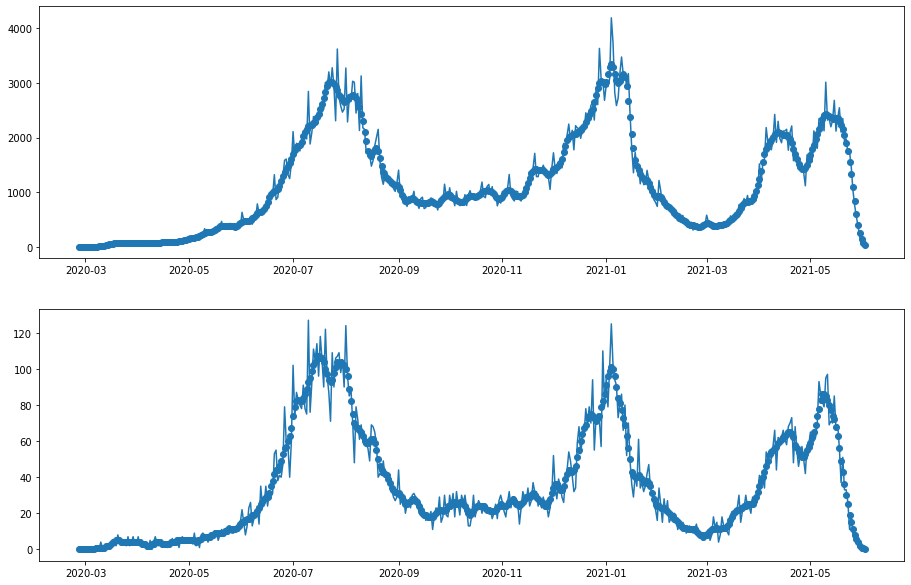

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(15.5, 10.2))

ax[0].plot(bog_agg_df.index.values, bog_agg_df["confirm"])
ax[0].scatter(bog_agg_df.index.values, bog_agg_df["smoothed_confirm"])

ax[1].plot(bog_agg_df.index.values, bog_agg_df["deaths"])
ax[1].scatter(bog_agg_df.index.values, bog_agg_df["smoothed_deaths"])

In [1]:
def trim(d, fields):
    if d is not None:
        d = {k : v for k, v in d.items() if k in fields}
    return d

def fit_forecast(data, pop=8181047, path_to_save=None):


    model = SEIRD(
        confirmed = data['confirmed'].cumsum(),
        death     = data['death'].cumsum(),
        T         = len(data),
        N         = int(8181047),
        )

    T_future = 100

    print("**** **** **** Fitting until {}".format(pd.to_datetime(data.index.values[-1]).strftime('%Y-%b-%d')))
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    samples = model.infer(num_warmup=400, num_samples=2000, num_chains=1)

    # In-sample posterior predictive samples (don't condition on observations)
    print(" * collecting in-sample predictive samples")
    post_pred_samples = model.predictive()

    # Forecasting posterior predictive (do condition on observations)
    print(" * collecting forecast samples")
    forecast_samples = model.forecast(T_future=T_future)

    save_fields=['beta0', 'beta', 'sigma', 'gamma', 'dy0', 'dy', 'mean_dy', 'mean_dy0',  'dy_future', 'mean_dy_future',
                    'dz0', 'dz', 'dz_future', 'mean_dz', 'mean_dz0', 'mean_dz_future',
                    'y0', 'y', 'y_future', 'z0', 'z', 'z_future' ]

    np.savez_compressed(os.path.join(path_to_save, 'samples.npz'),
                            mcmc_samples = samples,
                            post_pred_samples = post_pred_samples,
                            forecast_samples  = forecast_samples)

    forecast_samples['mean_dz0'] = forecast_samples["dz0"]
    forecast_samples['mean_dy0'] = forecast_samples["dy0"]

    deaths_fitted = model.combine_samples(forecast_samples, f='mean_dz', use_future=True)
    cases_fitted  = model.combine_samples(forecast_samples, f='mean_dy', use_future=True)

    df_deaths = create_df_response(deaths_fitted, time=len(data), date_init = pd.to_datetime(data.index.values[0]).strftime('%Y-%m-%d'),  forecast_horizon=100, use_future=True)
    df_cases  = create_df_response(cases_fitted, time=len(data), date_init  = pd.to_datetime(data.index.values[0]).strftime('%Y-%m-%d'),  forecast_horizon=100, use_future=True)

    df_deaths.to_csv( os.path.join(path_to_save, 'deaths_df.csv') )
    df_cases.to_csv(  os.path.join(path_to_save, 'cases_df.csv')  )

    return df_deaths, df_cases



In [21]:

# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab    = "Lockdown Imposed"


lockdowns = []
lockdowns.append({"code": "A",
                  "start_date" : pd.to_datetime("2020-07-13"),
                  "end_date"   : pd.to_datetime("2020-07-23"),
                  "places":["chapinero",
                            "los_martires",
                            "san_cristobal",
                            "tunjuelito",
                            "rafel_uribe_uribe",
                            "ciudad_bolivar",
                            "santa_fe",
                            "usme"]})

lockdowns.append({"code": "B",
                  "start_date" : pd.to_datetime("2020-07-23"),
                  "end_date"   : pd.to_datetime("2020-08-06"),
                  "places":["bosa",
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code": "C",
                  "start_date" : pd.to_datetime("2020-07-31"),
                  "end_date"   : pd.to_datetime("2020-08-14"),
                  "places":["suba",
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({"code": "D",
                  "start_date" : pd.to_datetime("2020-08-16"),
                  "end_date"   : pd.to_datetime("2020-08-27"),
                  "places":["usaquen",
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})


In [25]:
for loc in lockdowns:
    print("Fitting counterfactual for lockdown {}".format(loc["code"]))
    data = bog_agg_df.loc[:loc["start_date"]][["confirm", "deaths"]].rename(columns={"confirm": "confirmed", "deaths": "death"})
    df_deaths, df_cases = fit_forecast(data, pop=8181047, path_to_save=os.path.join( results_dir, 'conterfactuals', loc["code"]) )

Fitting counterfactual for lockdown A
**** **** **** Fitting until 2020-Jul-13


warmup:   8%|▊         | 190/2400 [03:49<43:24,  1.18s/it, 1023 steps of size 9.95e-08. acc. prob=0.73]